### dev notebook

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from nilearn.plotting import plot_stat_map#,plot_anat,plot_epi

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


#### helper functions (ignore)

In [2]:
def full_labels(csv_name, save=True):
    """getting full set of labels for features"""
    # load data
    print(f'./labels/label_{csv_name}.csv')
    labels = pd.read_csv(f'./labels/label_{csv_name}.csv')
    sj_bmrc = pd.read_csv(f'./bmrc_subjs/subjs_{csv_name}.csv', header=None)
    sj_full = pd.read_csv(f'./bmrc_full/subjs_{csv_name}.csv')
    # rename columns
    sj_bmrc.rename(columns={0:'bmrc'}, inplace=True)
    sj_full.rename(columns={'eid':'bmrc_eid'}, inplace=True)
    print(sj_full.shape)
    # merge
    bmrc_full = sj_bmrc.merge(sj_full, left_on='bmrc', right_on='bmrc_eid', how='left',indicator=True)
    # concat with labels
    full_df = pd.concat([labels, bmrc_full], axis=1)
    df_out = full_df[full_df['_merge']=='both']
    df_out_clean = df_out.drop(columns=['bmrc_eid', '_merge']).reset_index(drop=True)
    print(df_out_clean.shape)
    # save
    if save:
        save_path = f'./labels_full/label_{csv_name}.csv'
        df_out_clean.to_csv(save_path, index=None)
    return df_out_clean

In [3]:
def remove_subjs(feat_path, df_label):
    """remove participants with multiple conditions"""
    feats = np.load(os.path.join(feat_path, 'subj_course.npy'))
    exclude = df_label[df_label[['irritable bowel syndrome', 'back pain', 'migraine','osteoarthritis']].sum(axis=1)>1]['eid']
    df_featout = pd.concat([df_label, pd.DataFrame(feats)], axis=1)
    df_featout_ex = df_featout[~df_featout['eid'].isin(exclude.values)]
    return df_featout_ex

In [4]:
def data_prep(df):
    """prepare df to x and y for clf"""
    # dummify labels
    try:
        X = df[(str(n) for n in range(0,30))].to_numpy()
    except:
        X = df[(n for n in range(0,30))].to_numpy()

#     if df.shape[1]>33:
    if 'label' in df.columns:
        y = df['label']
    else:
        y_original = df[['irritable bowel syndrome', 'migraine', 'back pain',
       'osteoarthritis']]
        y = y_original.idxmax(axis=1)
    return X, y

In [5]:
def cv_classify(df, classifier='dtree', cv_fold=10, scaler=True, balance=True):
    """n-fold cross validation classification"""
    from sklearn.model_selection import cross_validate

    X, y = data_prep(df)
    # balance dataset
    if balance:
        from imblearn.under_sampling import RandomUnderSampler
        # define undersampling strategy
        under = RandomUnderSampler(random_state=0)
        # fit and apply the transform
        X, y = under.fit_resample(X, y)
    # apply scaler
    if scaler:
        from sklearn.preprocessing import StandardScaler
        X = StandardScaler().fit_transform(X)

    # define classifier
    if classifier == 'dtree':
        from sklearn.tree import DecisionTreeClassifier
        clf = DecisionTreeClassifier(max_depth=5)
    elif classifier == 'rforest':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(max_depth=5)
    elif classifier == 'lgb':
        import lightgbm as lgb
        clf = lgb.LGBMClassifier(n_jobs=-1)
    # cv result
    print(len(np.unique(y)))
    if len(np.unique(y)) <= 2: # binary
        cv_results = cross_validate(clf, X, y, cv=cv_fold, return_train_score=False, scoring=('accuracy', 'f1', 'roc_auc'))
        df_res = pd.DataFrame(cv_results)
        # print res
        print(f"{cv_fold}-fold CV classification with classifier {clf}:\n"
            f"test ROC AUC={df_res['test_roc_auc'].mean():.4f}, test accuracy={df_res['test_accuracy'].mean():.4f}, test f1={df_res['test_f1'].mean():.4f}")
    else:
        cv_results = cross_validate(clf, X, y, cv=cv_fold, return_train_score=False, scoring=('accuracy', 'f1_micro', 'roc_auc_ovo'))
        df_res = pd.DataFrame(cv_results)
        # print res
        print(f"{cv_fold}-fold CV classification with classifier {clf}:\n"
            f"test ROC AUC={df_res['test_roc_auc_ovo'].mean():.4f}, test accuracy={df_res['test_accuracy'].mean():.4f}, test f1={df_res['test_f1_micro'].mean():.4f}")

    return df_res


In [6]:
def load_mask(img_data):
    """load mask and return mask"""
    import nibabel as nib
    curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
    
    # check image shape
    img_len = img_data.shape[0]
    
    if img_len < 100: 
        mask_path = os.path.join(curr_dir, 'MNI152_T1_2mm_brain.nii.gz')
    else:
        mask_path = os.path.join(curr_dir, 'MNI152_T1_1mm_brain.nii.gz')
    mask_dat = nib.load(mask_path).get_fdata()>0
    return mask_dat

In [7]:
def feature_importance(clf, feature_names, plot=True):
    """plot feature importance and return series"""
    import time
    import numpy as np

    start_time = time.time()
    importances = clf.feature_importances_
    std = np.std([
        tree.feature_importances_ for tree in clf.estimators_], axis=0)
    # importance
    import matplotlib.pyplot as plt
    feat_importances = pd.Series(importances, index=feature_names)
    # plot
    if plot:
        fig, ax = plt.subplots()
        feat_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
    return feat_importances.sort_values(ascending=False)

In [8]:
def top_mods(data_dir, feature_importance, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
    top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[topIC.argsort()]
#     print(plot_mod.index.max())
    print('top modalities', plot_mod.iloc[-mod_num:])
    if plot:
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(8,4))
        plt.bar(np.arange(len(topIC)), topIC[topIC.argsort()])
        plot_mod_names = plot_mod['modalities'].values
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
    return top_feat, plot_mod.index[-mod_num:].values[::-1]

#### plotting cv

In [9]:
df_cv = pd.read_csv('./hyperparam_cv/patients_optuna.csv')

In [18]:
df_comp = df_cv.groupby(['IC number'])[['test_roc_auc_ovo', 'test_accuracy']].mean()

In [20]:
df_comp

,test_roc_auc_ovo,test_accuracy
IC number,,
30,0.569270,0.312000
50,0.571221,0.304667
100,0.573400,0.320667
150,0.568627,0.314000
200,0.580694,0.330000


In [23]:
bestIC = df_comp.index[df_comp['test_roc_auc_ovo'].argmax()]

In [26]:
params = df_cv[df_cv['IC number'] == bestIC].mean()[['max_depth', 'n_estimators', 'max_features',
                                                   'min_samples_split', 'min_samples_leaf', 'max_samples' ]]

In [27]:
params

max_depth              5.000000
n_estimators         225.000000
max_features           0.725842
min_samples_split      9.000000
min_samples_leaf      11.000000
max_samples            0.935601
dtype: float64

(0.5, 0.6)

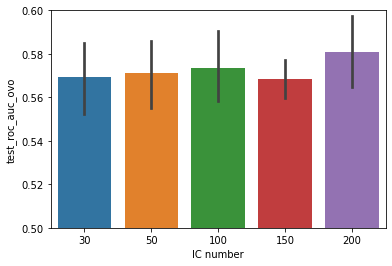

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=df_cv, x='IC number', y='test_roc_auc_ovo')
plt.ylim(0.5,0.6)

#### export npy names

In [9]:
base_dir = '/well/seymour/users/uhu195/python/'
sj_dir = 'extract_npy/npy/subjs_patients_pain'
# sj_dir = 'extract_npy/npy/subjs_digestive'
npy_dir = os.path.join(base_dir, sj_dir)

# get all npys
npy_ls = os.listdir(npy_dir)
npy_path = [os.path.join(npy_dir, f) for f in npy_ls]

In [27]:
npys = pd.DataFrame({'modalities':[n.split('/')[-1].split('.')[0] for n in npy_path]})

In [30]:
npys.to_csv('./sorted_feats.csv', index=None)

### CV on patient dataset

In [10]:
df_out = full_labels('patients_pain', save=False)

./labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


In [20]:
# data_dir = '../pain/output_patients/Result_IC30'
data_dir = '../pain/output_patients_50/Result_IC50'

In [21]:
df_featout_ex = remove_subjs(data_dir, df_out)

In [22]:
df_featout_ex.shape

(2280, 56)

In [26]:
# df_featout_ex.to_csv('./bfl_output/patient_IC30_label.csv', index=None)
df_featout_ex.to_csv('./bfl_output/patient_IC50_label.csv', index=None)

In [25]:
_ = cv_classify(df_featout_ex, classifier='rforest', cv_fold=10, scaler=True, balance=True) # 50 nlat

4
10-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5710, test accuracy=0.3200, test f1=0.3200


In [19]:
_ = cv_classify(df_featout_ex, classifier='rforest', cv_fold=10, scaler=True, balance=True) # 30 nlat

4
10-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5548, test accuracy=0.2953, test f1=0.2953


### optuna on patient dataset

In [30]:
import optuna

In [65]:
def load_feats(dataset, train=True, balance=False, scaler=False):
    """load dataset from csv, return full or train sets"""
    if dataset == 'patient':
        data = pd.read_csv('./bfl_output/patient_IC30_label.csv')
    elif dataset == 'patient_50':
        data = pd.read_csv('./bfl_output/patient_IC50_label.csv')
    elif dataset == 'digestive':
        data = pd.read_csv('./bfl_output/digestive_IC30_label.csv')
    elif dataset == 'digestive_50':
        data = pd.read_csv('./bfl_output/digestive_IC50_label.csv')
    else:
        return ValueError('dataset does not exist')
    X, y = data_prep(data)
    
    # balance dataset
    if balance:
        from imblearn.under_sampling import RandomUnderSampler
        # define undersampling strategy
        under = RandomUnderSampler(random_state=0)
        # fit and apply the transform
        X, y = under.fit_resample(X, y)
    # apply scaler
    if scaler:
        from sklearn.preprocessing import StandardScaler
        X = StandardScaler().fit_transform(X)
        
    # return full or train only
    if train:
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=42)
        return X_train, y_train
    else:
        return X, y
    

In [32]:
def objective(trial):
    """tuning using optuna"""
    from sklearn.model_selection import train_test_split
    import sklearn.ensemble
    import sklearn.model_selection
    
#     X, y = load_feats(dataset='patient', train=False)
    X, y = load_feats(dataset='patient_50', train=False)

    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
    rf_n_estimators = trial.suggest_categorical('rf_n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('rf_max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('rf_max_samples', 0.6, 0.99)
            
    classifier_obj = sklearn.ensemble.RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features, 
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
        bootstrap=True, verbose=0
    )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, 
                                                    n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2021-10-05 11:34:57,640] A new study created in memory with name: no-name-ddbde8b2-4a04-4f09-9f24-c6fce792111b
[I 2021-10-05 11:35:07,760] Trial 0 finished with value: 0.3907894736842105 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4, 'rf_n_estimators': 225, 'rf_max_features': 0.7968588599996085, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 14, 'rf_max_samples': 0.9459187979310769}. Best is trial 0 with value: 0.3907894736842105.
[I 2021-10-05 11:35:09,958] Trial 1 finished with value: 0.38903508771929823 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2, 'rf_n_estimators': 200, 'rf_max_features': 0.6904568429333879, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 14, 'rf_max_samples': 0.9385404009299152}. Best is trial 0 with value: 0.3907894736842105.
[I 2021-10-05 11:35:11,844] Trial 2 finished with value: 0.3942982456140351 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5, 'rf_n_estimators': 125, 'rf_max_features': 0.960009

In [34]:
bp = study.best_trial.params
print(bp)

{'classifier': 'RandomForest', 'rf_max_depth': 6, 'rf_n_estimators': 175, 'rf_max_features': 0.2413326526108331, 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 5, 'rf_max_samples': 0.8409713196606543}


In [35]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(
    max_depth=bp['rf_max_depth'], n_estimators=bp['rf_n_estimators'], max_features=bp['rf_max_features'], 
    min_samples_split=bp['rf_min_samples_split'], min_samples_leaf=bp['rf_min_samples_leaf'], max_samples=bp['rf_max_samples'])
# load data
# X_train, y_train = load_feats(dataset='patient', train=True)
X_train, y_train = load_feats(dataset='patient_50', train=True)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2413326526108331,
                       max_samples=0.8409713196606543, min_samples_leaf=5,
                       min_samples_split=13, n_estimators=175)

In [36]:
y_train.value_counts()/y_train.shape[0]

osteoarthritis              0.388304
irritable bowel syndrome    0.280117
migraine                    0.167251
back pain                   0.164327
dtype: float64

In [37]:
score = sklearn.model_selection.cross_val_score(forest, X_train, y_train, n_jobs=-1, cv=3)
print(score)

[0.40175439 0.39824561 0.37368421]


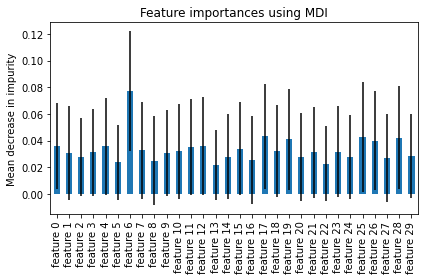

In [38]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]
feature_imp = feature_importance(forest, feature_names)

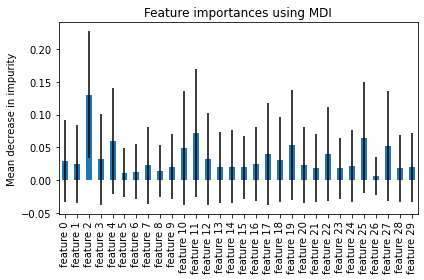

In [216]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]
feature_imp = feature_importance(forest, feature_names)

In [39]:
# data_dir = '../pain/output_patients/Result_IC30'
data_dir = '../pain/output_patients_50/Result_IC50'

top feature: 6
top modalities    modalities
43     zstat5
44      cope1
34      cope2
8      zstat1
40     zstat2


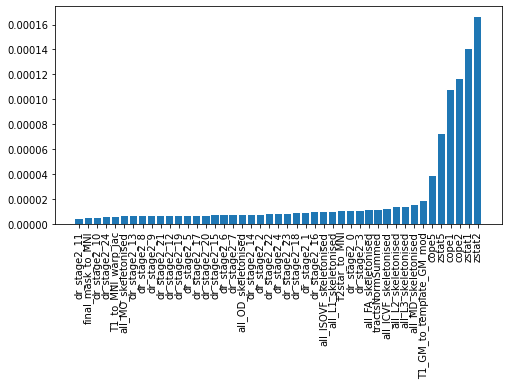

In [48]:
top_feat, mod_ls = top_mods(data_dir, feature_imp, mod_num=5)

In [49]:
def load_modZ(data_dir, modality_num, feature_num, plot_threshold, plot_coords=[0, 0, 0], plot=True):
    """load modality Z map given number"""
    import nibabel as nib
    from nibabel import Nifti1Image

    df_mod = np.load(os.path.join(data_dir, f'flica_mod{modality_num+1}_Z.npy'))
    print(df_mod.shape)
    img_data = df_mod[:,feature_num]
    # load mask by shape
    if df_mod.shape[0]>1e6:
        mask_path = './MNI152_T1_1mm_brain.nii.gz'
    else:
        mask_path = './MNI152_T1_2mm_brain.nii.gz'
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata()
    mask = np.where(mask_data>0)
    # reshape z map
    img_reshape = np.zeros(mask_data.shape)
    img_reshape[mask] = img_data
    # reconstruct using MNI affine
    img_reshape_ni = Nifti1Image(img_reshape, affine=mask_img.affine)
    # load modality names
    mod_names = pd.read_csv('./sorted_feats.csv')
    # plotting
    if plot:
        plot_mod = mod_names.iloc[modality_num].values
        plot_stat_map(img_reshape_ni, bg_img=mask_path, threshold=plot_threshold, cut_coords=plot_coords, title=plot_mod[0])
    return img_reshape_ni, mask_path

modality 40
(228453, 50)
modality 8
(228453, 50)
modality 34
(228453, 50)
modality 44
(228453, 50)
modality 43
(228453, 50)


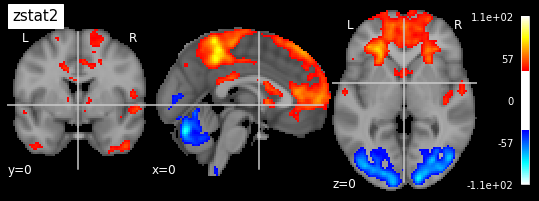

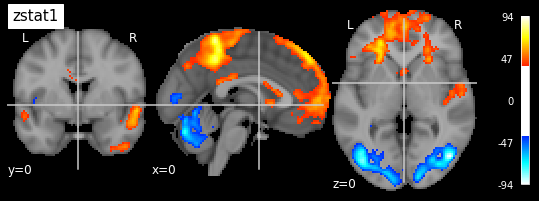

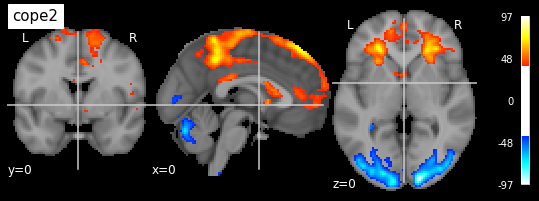

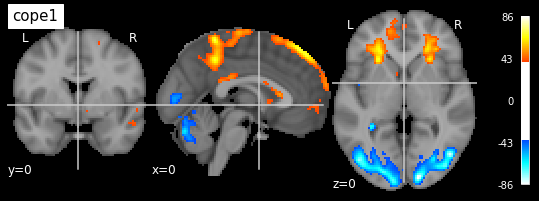

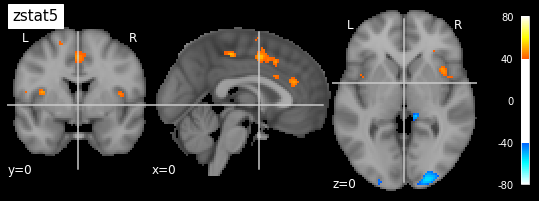

In [52]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=40)

### CV on digestive dataset

In [53]:
df_label = full_labels('digestive')

./labels/label_digestive.csv
(3817, 1)
(3817, 3)


In [54]:
# data_dir = '../pain/output_digestive/Result_IC30'
data_dir = '../pain/output_digestive_50/Result_IC50'
feats = np.load(os.path.join(data_dir, 'subj_course.npy'))

In [55]:
feats.shape

(3817, 50)

In [56]:
df_featout = pd.concat([df_label, pd.DataFrame(feats)], axis=1)

In [57]:
df_featout.shape

(3817, 53)

In [61]:
# df_featout.to_csv('./bfl_output/digestive_IC30_label.csv', index=None)
df_featout.to_csv('./bfl_output/digestive_IC50_label.csv', index=None)

In [64]:
_ = cv_classify(df_featout, classifier='rforest', cv_fold=10, 
            scaler=True, balance=True)

2
10-fold CV classification with classifier RandomForestClassifier(max_depth=5):
test ROC AUC=0.5931, test accuracy=0.5745, test f1=0.5694


### optuna on digestive dataset

In [66]:
def objective(trial):
    """tuning using optuna"""
    from sklearn.model_selection import train_test_split
    import sklearn.ensemble
    import sklearn.model_selection
    
#     X, y = load_feats(dataset='digestive', train=False, balance=True, scaler=True)
    X, y = load_feats(dataset='digestive_50', train=False, balance=True, scaler=True)

    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
    rf_n_estimators = trial.suggest_categorical('rf_n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('rf_max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('rf_max_samples', 0.6, 0.99)
            
    classifier_obj = sklearn.ensemble.RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features, 
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
        bootstrap=True, verbose=0
    )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, 
                                                    n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [67]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2021-10-05 13:30:27,075] A new study created in memory with name: no-name-8b0361a7-9a22-41c9-85a0-7e0b6c6ea62f
[I 2021-10-05 13:30:38,687] Trial 0 finished with value: 0.5748683220466516 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 9, 'rf_n_estimators': 175, 'rf_max_features': 0.8578313646161547, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 13, 'rf_max_samples': 0.7654972307275258}. Best is trial 0 with value: 0.5748683220466516.
[I 2021-10-05 13:30:39,474] Trial 1 finished with value: 0.5729872084273889 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2, 'rf_n_estimators': 50, 'rf_max_features': 0.4091028390400824, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 6, 'rf_max_samples': 0.6862617061343392}. Best is trial 0 with value: 0.5748683220466516.
[I 2021-10-05 13:30:42,604] Trial 2 finished with value: 0.5744920993227991 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5, 'rf_n_estimators': 200, 'rf_max_features': 0.9898679

In [69]:
bp = study.best_trial.params
print(bp)

{'classifier': 'RandomForest', 'rf_max_depth': 11, 'rf_n_estimators': 200, 'rf_max_features': 0.41881728157295983, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 4, 'rf_max_samples': 0.6540604343632286}


In [70]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(
    max_depth=bp['rf_max_depth'], n_estimators=bp['rf_n_estimators'], max_features=bp['rf_max_features'], 
    min_samples_split=bp['rf_min_samples_split'], min_samples_leaf=bp['rf_min_samples_leaf'], max_samples=bp['rf_max_samples'])
# load data
# X_train, y_train = load_feats(dataset='digestive', train=True, balance=True, scaler=True)
X_train, y_train = load_feats(dataset='digestive_50', train=True, balance=True, scaler=True)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features=0.41881728157295983,
                       max_samples=0.6540604343632286, min_samples_leaf=4,
                       min_samples_split=11, n_estimators=200)

In [71]:
y_train.value_counts()/y_train.shape[0]

1    0.500251
0    0.499749
Name: label, dtype: float64

In [72]:
y_train.value_counts()

1    997
0    996
Name: label, dtype: int64

In [73]:
score = sklearn.model_selection.cross_val_score(forest, X_train, y_train, n_jobs=-1, cv=3)
print(score)

[0.57142857 0.55873494 0.53614458]


X = bigflica (30)
y = [1-severe pain, 0-no pain (after x years)]

y - multitask + nIDPs

X = bigflica (30)
y = [1-severe pain, 0-no pain (after x years, t=x)]+ nIDPs (t=0)

nIDP - questionnaire

pytorch - 

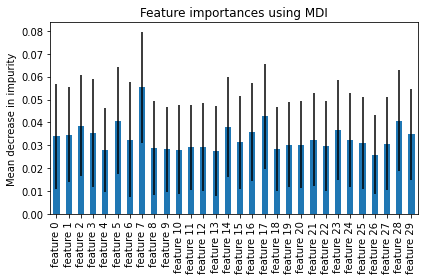

In [74]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])] # 50
feature_imp = feature_importance(forest, feature_names)

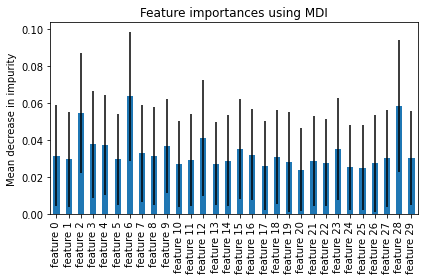

In [84]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])] # 30
feature_imp = feature_importance(forest, feature_names)

top feature: 7
top modalities                   modalities
9   T1_GM_to_template_GM_mod
34                     cope2
44                     cope1
40                    zstat2
8                     zstat1


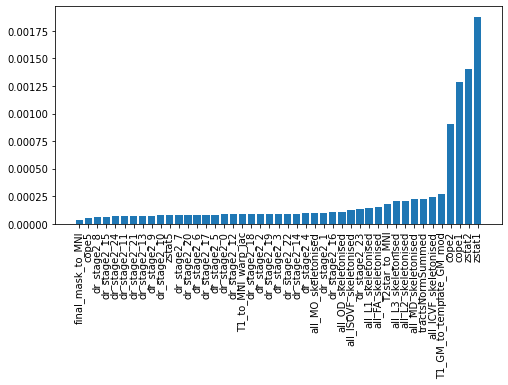

In [77]:
top_feat, mod_ls = top_mods(data_dir, feature_imp, mod_num=5)

modality 8
(228453, 50)
modality 40
(228453, 50)
modality 44
(228453, 50)
modality 34
(228453, 50)
modality 9
(228453, 50)


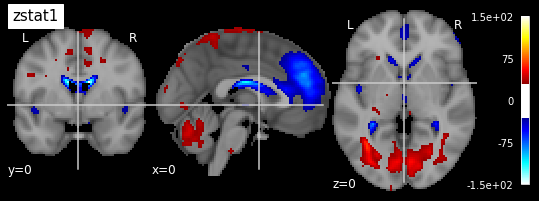

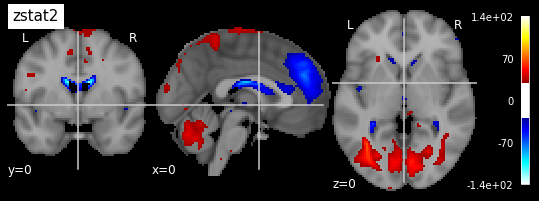

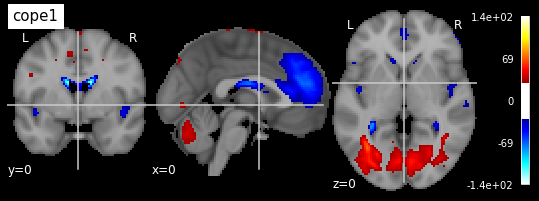

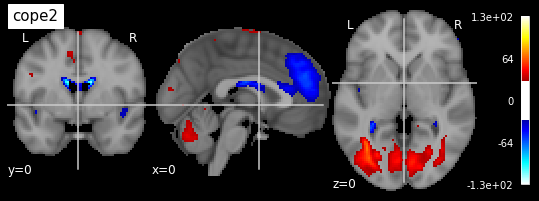

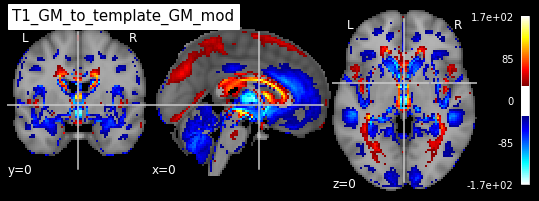

In [79]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=30)

#### 30 nlat results

(1827095, 30)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


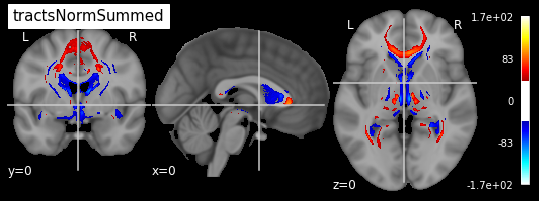

In [197]:
reshape_z, mask_path = load_modZ(data_dir, modality_num=27, feature_num=6, plot_threshold=40)
# plot_stat_map(reshape_z, bg_img=mask_path, threshold=40, cut_coords=[0, 0, 0])

(1827095, 30)


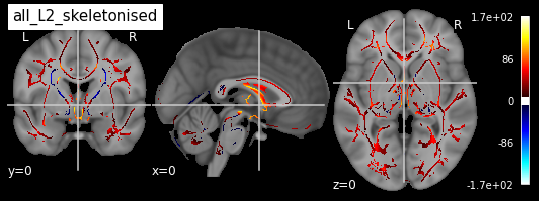

In [200]:
reshape_z, mask_path = load_modZ(data_dir, modality_num=11, feature_num=6, plot_threshold=10)
# plot_stat_map(reshape_z, bg_img=mask_path, threshold=10, cut_coords=[0, 0, 0])

(228453, 30)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


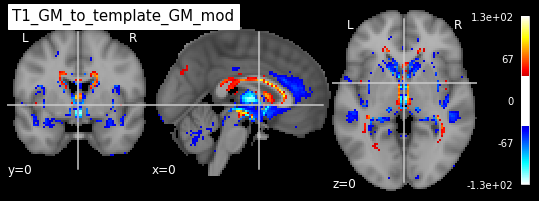

In [201]:
reshape_z, mask_path = load_modZ(data_dir, modality_num=9, feature_num=6, plot_threshold=40)
# plot_stat_map(reshape_z, bg_img=mask_path, threshold=30, cut_coords=[0, 0, 0])
# plot_stat_map(reshape_z, bg_img=mask_path, threshold=40, cut_coords=[0, 0, -10])

(1827095, 30)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


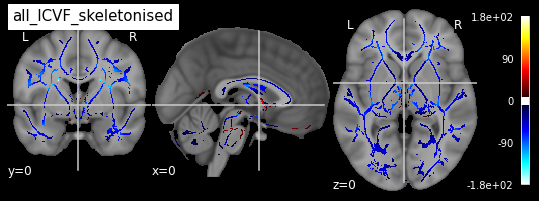

In [202]:
reshape_z, mask_path = load_modZ(data_dir, modality_num=12, feature_num=6, plot_threshold=10)
# plot_stat_map(reshape_z, bg_img=mask_path, threshold=10, cut_coords=[0, 0, 0])

(228453, 30)


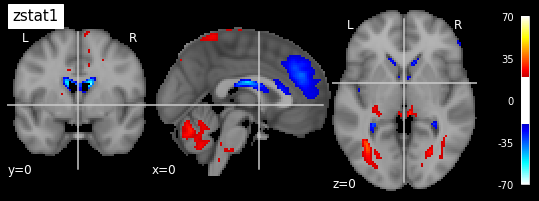

In [207]:
reshape_z, mask_path = load_modZ(data_dir, modality_num=8, feature_num=6, plot_threshold=20)
# plot_stat_map(reshape_z, bg_img=mask_path, threshold=0, cut_coords=[0, 0, 0])

(1827095, 30)


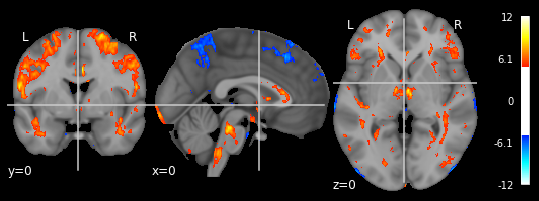

In [149]:
reshape_z, mask_path = load_modZ(data_dir, modality_num=29, feature_num=28)
plot_stat_map(reshape_z, bg_img=mask_path, threshold=5, cut_coords=[0, 0, 0])